In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gpsomopt import *
import GPyOpt
import os
import shutil
from shepard import *

parent_dir = 'gpsomopt_raw'
if os.path.isdir(parent_dir):
    shutil.rmtree(parent_dir)
os.mkdir(parent_dir)

f_class = GPyOpt.objective_examples.experiments2d.branin
f_true = f_class()
bounds = [{'name':'var_1', 'type': 'continuous', 'domain': f_true.bounds[0]}
        , {'name':'var_2', 'type': 'continuous', 'domain': f_true.bounds[1]}]

space = Design_space(bounds, None)
x = initial_design('random', space, 200)
y = f_true.f(x)
px = initial_design('random', space, 1)[0]
# px = np.array([0, 12])

In [3]:
from GPyOpt.core.task.space import *
bounds = bounds_to_space(f_true.bounds)

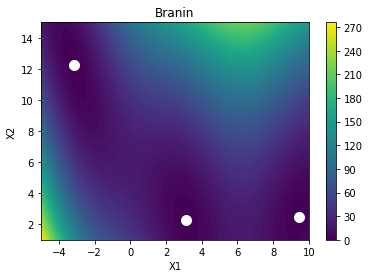

In [5]:
import GPyOpt
import matplotlib.pyplot as plt
f_class = GPyOpt.objective_examples.experiments2d.branin
f_true = f_class()
f_true.plot()
plt.show()

In [9]:
import shepard
import imp
imp.reload(shepard)
from shepard import *

In [7]:
def get_fitness(px, x, y, bd = None):
    v = x - px
    g = gradient_shepard_v3(x, y, px, bd = bd, N_min = 5, N_max = 10)
    cos_theta = 0.5 * (-np.dot(g, v.transpose())/(norm(g) * norm(v, axis = 1)) + 1)
    w = norm(v) * (cos_theta ** norm(g))
    return w

bd = np.asarray(space.get_bounds())
w = get_fitness(px, x, y, bd)


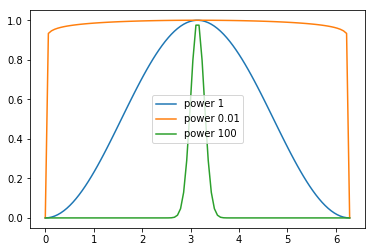

In [61]:
# heuristics after fitness function
# higher |g| leads to 'more picky' to direction
# lower |g| leads to 'less picky' to direction
x = np.linspace(0, 2*np.pi, 100)
y1 = 0.5 * (-np.cos(x) + 1)
y2 = (0.5 * (-np.cos(x) + 1))**0.01
y3 = (0.5 * (-np.cos(x) + 1))**100
plt.figure()
plt.plot(x, y1, label = 'power 1')
plt.plot(x, y2, label = 'power 0.01')
plt.plot(x, y3, label = 'power 100')
plt.legend()

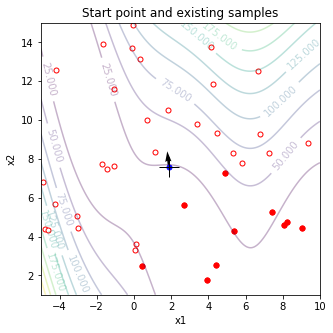

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from pylab import savefig
from shepard import *

# Randomly generate 40 samples [x]s and their evaluations
# and 1 start point [px]
space = Design_space(bounds, None)
x = initial_design('random', space, 40)
y = f_true.f(x)
px = initial_design('random', space, 1)[0]

# Function: compute a fitness function for subset selection
#           fitness(x) = 0.5 * (-cos(g(px) * g(x))/|g(px)||g(x)| + 1)
# Arg: [px]: Start Point
#      [x]:  Existing inputs
#      [y]:  Existing outputs
#      [bd]: Lower & upper bounds for inputs (in array like [lb, ub])
#            set to None by default, use [-1, 1]^d for bounds
def get_fitness(px, x, y, bd = None, N_min = 10, N_max = 20):
    v = x - px
    g = gradient_shepard_v3(x, y, px, bd = bd, N_min = 5, N_max = 10)
    # w = 1/(np.dot(g, v.trafnspose()) + norm(g) * norm(v))
    cos_theta = 0.5 * (-np.dot(g, v.transpose())/(norm(g) * norm(v, axis = 1)) + 1)
    w = norm(v) * (cos_theta ** norm(g))
    return w

# Function: compute a fitness function for subset selection
#           fitness(x) = 0.5 * (-cos(g(px) * g(x))/|g(px)||g(x)| + 1)^(|g|)
# Arg: [px]: Start Point
#      [x]:  Existing inputs
#      [y]:  Existing outputs
#      [bd]: Lower & upper bounds for inputs (in array like [lb, ub])
#            set to None by default, use [-1, 1]^d for bounds
def get_fitness2(px, x, y, bd = None, N_min = 10, N_max = 20):
    v = x - px
    g = gradient_shepard_v3(x, y, px, bd = bd, N_min = N_min, N_max = N_max)
    cos_theta = 0.5 * (-np.dot(g, v.transpose())/(norm(g) * norm(v, axis = 1)) + 1)*norm(g)
    w = norm(v) * (cos_theta ** norm(g))
    return w

bd = np.asarray(space.get_bounds())
w = get_fitness(px, x, y, bd)

# Function: Draw a subset from given existing samples
# Arg: [x] & [y]: Existing samples inputs & outputs
#      [f] Objective function
#      [bd] bounds
#      [px] start point
#      g_alpha: ratio to gradients
def draw_subset(x, y, f, bd, num, px = None, g_alpha = 1.0):
    
    # [x] and [y] must match in size
    if len(x) != len(y):
        return
    
    # Define a dimension 2 plot
    plt.figure(figsize = (5, 5))
    X1 = np.linspace(bd[0][0], bd[0][1], 200)
    X2 = np.linspace(bd[1][0], bd[1][1], 200)
    x1, x2 = np.meshgrid(X1, X2)
    X = np.hstack((x1.reshape(200 * 200, 1), x2.reshape(200 * 200, 1)))
    Y = f(X)
    cs1 = plt.contour(x1, x2, Y.reshape(200,  200), 10, alpha = 0.3)
    plt.clabel(cs1, inline = 1)
    
    # compute fitness
    w = get_fitness(px, x, y, bd = bd, N_min = 10, N_max = 20)
    
    # find subset of [num] size
    if(num >= len(x)):
        num = len(x)
    indices = np.argsort(-w)
    sub_indices = indices[:num]
    sx = x[sub_indices]
            
    # draw samples [x]s and start point [px]
    plt.plot(x[:, 0], x[:, 1], 'w.', markeredgecolor = 'r', markersize = 10, zorder = 0)
    plt.plot(px[0], px[1], 'b.', markersize = 10, zorder = 1)
    plt.plot(px[0], px[1], 'k+', markersize = 20, zorder = 2)
    plt.plot(sx[:, 0], sx[:, 1], 'r.', markersize = 10, zorder = 1)
    
    # comments
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Start point and existing samples')
    
    # plot quiver of gradient of start point
    gp = gradient_shepard_v3(x, y, px, bd = bd, N_min = 10, N_max = 20)
    gp = g_alpha * gp
    plt.quiver(px[0], px[1], gp[0], gp[1])
    
def draw_subset_raw(x, y, f, bd, px = None, sx = None):
    # draw subset
    plt.plot(x[:, 0], x[:, 1], 'w.', markeredgecolor = 'r', markersize = 10, zorder = 0)
    plt.plot(sx[:,0], sx[:,1], 'b.', markersize = 10, zorder = 1)
    plt.plot(px[0], px[1], 'b.', markersize = 10, zorder = 1)
    plt.plot(px[0], px[1], 'k+', markersize = 20, zorder = 2)
    # plt.text(px[0], px[1], str(w), va = 'top')
    # for i in np.arange(len(x)):
    #     textline = "%0.2f" % w[i]
    #     plt.text(x[i, 0], x[i, 1] - 0.1, textline, va = 'top')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Start point and existing samples')

g_alpha = 10000
bd = np.asarray(space.get_bounds())
draw_subset(x, y, f_true.f, bd, num = 10, px = px)